In [ ]:
import pandas as pd


In [ ]:
# Load datasets
application_record = pd.read_csv('application_record.csv')
print(application_record.info())
# print(application_record.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
credit_record = pd.read_csv('credit_record.csv')
print(credit_record.info())
print(credit_record.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None
        ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C


In [ ]:
# Merge the data on 'ID' to drop any rows in application_record that don't have a corresponding entry in credit_record
merged_data = pd.merge(application_record, credit_record, on='ID', how='inner')

# Inspect the merged data
print(merged_data.info())
print(merged_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

### Label Creation

#### Good (0):<br>

Includes statuses that indicate either no overdue payments or minor delays:<br>
* 0 (1-29 days past due): Slight delay, but not significant.<br>
* C (Paid off that month): Indicates repayment.<br>
* X (No loan for the month): No risk since there’s no active loan.<br>

#### Bad (1):<br>

--------
Includes statuses that indicate severe delays or write-offs:<br>
* 1 (30-59 days past due): Moderate delay.
* 2 (60-89 days past due): Significant delay.
* 3 (90-119 days overdue): Very late payments.
* 4 (120-149 days overdue): Severe overdue payments.
* 5 (Overdue or bad debts, write-offs for more than 150 days): Indicates default or write-off.

In [ ]:
# # Define a mapping function for the label
# def map_status_to_label(statuses):
#     # If any status in the list is bad ('1', '2', '3', '4', '5'), label as 'Bad'
#     if any(s in ['1', '2', '3', '4', '5'] for s in statuses):
#         return 'Bad'
#     # Otherwise, label as 'Good' (only '0', 'C', 'X' are present)
#     return 'Good'

# # Group by 'ID' and collect all statuses for each client
# credit_behavior = credit_record.groupby('ID')['STATUS'].apply(list).reset_index()

# # Apply the function to assign labels
# credit_behavior['label'] = credit_behavior['STATUS'].apply(map_status_to_label)


# # Display the resulting DataFrame
# print(credit_behavior.head())



In [ ]:
# Define updated weights for each STATUS
status_weights = {
    '0': 1,   # 1-29 days past due
    'C': -1,   # Paid off
    'X': 0,   # No loan
    '1': 2,   # 30-59 days past due
    '2': 3,   # 60-89 days overdue
    '3': 4,   # 90-119 days overdue
    '4': 5,   # 120-149 days overdue
    '5': 6    # Overdue or bad debts > 150 days
}

# Define a threshold for labeling
threshold =18

# Function to calculate the weighted sum and assign a label
def calculate_label(statuses):
    # Remove any NaN or invalid statuses
    valid_statuses = [status for status in statuses if status in status_weights]
    # Calculate the total weight for valid statuses
    total_weight = sum(status_weights[status] for status in valid_statuses)
    # Assign label based on threshold
    return 'Bad' if total_weight > threshold else 'Good'

# Group by 'ID' and collect all statuses for each client
credit_behavior = merged_data.groupby('ID')['STATUS'].apply(list).reset_index()

# Apply the function to calculate the label
credit_behavior['label'] = credit_behavior['STATUS'].apply(calculate_label)

# Optional: Convert the label to binary (0 for Good, 1 for Bad)
# merged_behavior['label'] = merged_behavior['label'].map({'Good': 0, 'Bad': 1})

# Merge the labels back into the original merged_data
final_data = pd.merge(merged_data, credit_behavior[['ID', 'label']], on='ID', how='inner')

# Inspect the resulting DataFrame
print(final_data.info())
print(final_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   777715 non-null  int64  
 1   CODE_GENDER          777715 non-null  object 
 2   FLAG_OWN_CAR         777715 non-null  object 
 3   FLAG_OWN_REALTY      777715 non-null  object 
 4   CNT_CHILDREN         777715 non-null  int64  
 5   AMT_INCOME_TOTAL     777715 non-null  float64
 6   NAME_INCOME_TYPE     777715 non-null  object 
 7   NAME_EDUCATION_TYPE  777715 non-null  object 
 8   NAME_FAMILY_STATUS   777715 non-null  object 
 9   NAME_HOUSING_TYPE    777715 non-null  object 
 10  DAYS_BIRTH           777715 non-null  int64  
 11  DAYS_EMPLOYED        777715 non-null  int64  
 12  FLAG_MOBIL           777715 non-null  int64  
 13  FLAG_WORK_PHONE      777715 non-null  int64  
 14  FLAG_PHONE           777715 non-null  int64  
 15  FLAG_EMAIL       

### Data Integration


In [ ]:


# Merge the labels from credit_behavior into the merged_data
final_data = pd.merge(merged_data, credit_behavior[['ID', 'label']], on='ID', how='inner')

# Drop duplicate IDs if there are any
final_data = final_data.drop_duplicates(subset=['ID'])

# Check if there are any remaining duplicates
print(final_data['ID'].duplicated().sum())  # Should print 0 if there are no duplicates
print(final_data.head())


0
         ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0   5008804           M            Y               Y             0   
16  5008805           M            Y               Y             0   
31  5008806           M            Y               Y             0   
61  5008808           F            N               Y             0   
66  5008809           F            N               Y             0   

    AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0           427500.0               Working               Higher education   
16          427500.0               Working               Higher education   
31          112500.0               Working  Secondary / secondary special   
61          270000.0  Commercial associate  Secondary / secondary special   
66          270000.0  Commercial associate  Secondary / secondary special   

      NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  ...  DAYS_EMPLOYED  FLAG_MOBIL  \
0         Civil marriage   Rented a

In [ ]:
print(final_data['label'].value_counts())

label
Good    33514
Bad      2943
Name: count, dtype: int64


### Clean Data

In [ ]:
# Check for missing values
print(final_data.isnull().sum())


ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
MONTHS_BALANCE             0
STATUS                     0
label                      0
dtype: int64


In [ ]:
# Fill null values in the 'OccupationType' column with 'Unknown'
final_data['OCCUPATION_TYPE'] = final_data['OCCUPATION_TYPE'].fillna('Unknown')
# Drop the 'STATUS' column
final_data = final_data.drop(columns=['STATUS'])


In [ ]:
print(final_data.isnull().sum())


ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
MONTHS_BALANCE         0
label                  0
dtype: int64


### Encode Categorical Variables

In [ ]:
print(final_data.head())

         ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0   5008804           M            Y               Y             0   
16  5008805           M            Y               Y             0   
31  5008806           M            Y               Y             0   
61  5008808           F            N               Y             0   
66  5008809           F            N               Y             0   

    AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0           427500.0               Working               Higher education   
16          427500.0               Working               Higher education   
31          112500.0               Working  Secondary / secondary special   
61          270000.0  Commercial associate  Secondary / secondary special   
66          270000.0  Commercial associate  Secondary / secondary special   

      NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0         Civil marriage   Rented apartmen

In [ ]:

import pandas as pd

# Perform one-hot encoding for categorical columns in final_data
categorical_columns = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]
final_data = pd.get_dummies(final_data, columns=categorical_columns, drop_first=True)


### Normalize/Scale Numerical Variables

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define the scaler
scaler = MinMaxScaler()

# Columns to scale
numerical_columns = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']

# Apply scaling
final_data[numerical_columns] = scaler.fit_transform(final_data[numerical_columns])


In [ ]:
print(final_data['label'].isnull().sum())

0


### Prepare Data for Modeling

In [ ]:
# Define the features and target variable
y = final_data['label'].map({'Good': 0, 'Bad': 1})  # Convert labels to binary (0 for 'Good', 1 for 'Bad')
X = final_data.drop(['ID', 'label'], axis=1)  # Drop 'ID' and 'label' columns from features


In [ ]:
print(y.isnull().sum())

0


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns


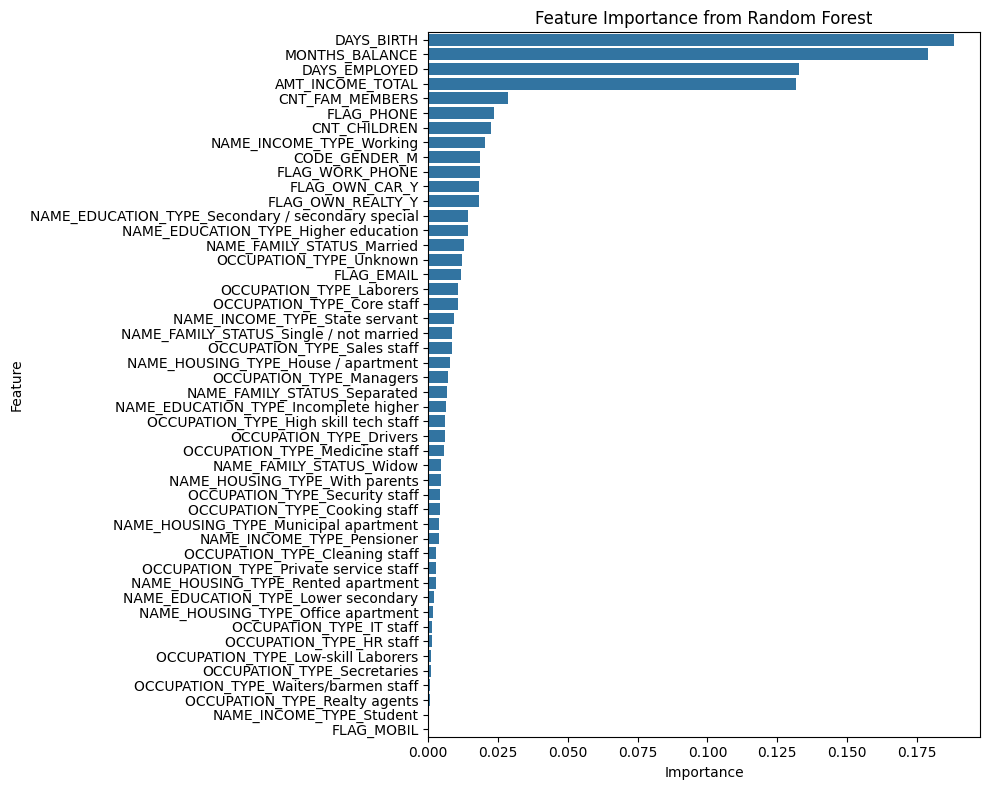

In [ ]:

# Train the Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importance = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Horizontal bar plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:

low_importance_features =[
    'NAME_INCOME_TYPE_Student',
    'OCCUPATION_TYPE_IT staff',
    'OCCUPATION_TYPE_HR staff',
    'OCCUPATION_TYPE_Low-skill Laborers',
    'FLAG_MOBIL',
    'OCCUPATION_TYPE_Private service staff',
    'OCCUPATION_TYPE_Realty agents',
    'OCCUPATION_TYPE_Waiters/barmen staff',
    'OCCUPATION_TYPE_Secretaries',

]


X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)



In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

### Train-Test Split

## Model Training


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

# Apply SMOTE to oversample the minority class in the training data
smote = SMOTE(random_state=42)
# Resample the training data
X_res, y_res = smote.fit_resample(X_train_reduced, y_train)
X_res_test, y_res_test = smote.fit_resample(X_test_reduced, y_test)
print(sum(y_res==1),sum(y_res==0))
print(sum(y_res_test==1),sum(y_res_test==0))


23467 23467
10047 10047


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with balanced class weights
logreg = LogisticRegression(max_iter=1000,class_weight='balanced', random_state=42)

# Train the logistic regression model on the resampled data
logreg.fit(X_res, y_res)

# Make predictions on the test set
y_pred = logreg.predict(X_res_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_res_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_res_test, y_pred))


Accuracy: 0.57

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.52      0.55     10047
           1       0.56      0.61      0.59     10047

    accuracy                           0.57     20094
   macro avg       0.57      0.57      0.57     20094
weighted avg       0.57      0.57      0.57     20094



In [ ]:

# Initialize Random Forest Classifier with balanced class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model on the resampled data
rf.fit(X_res, y_res)

# Make predictions
y_pred_rf = rf.predict(X_res_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_res_test, y_pred_rf):.2f}")
print("\nClassification Report:")
print(classification_report(y_res_test, y_pred_rf))


Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     10047
           1       0.95      0.78      0.85     10047

    accuracy                           0.87     20094
   macro avg       0.88      0.87      0.87     20094
weighted avg       0.88      0.87      0.87     20094



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the SVM model with a linear kernel
svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Train the SVM model on the training data
svm_linear.fit(X_res, y_res)

# Make predictions on the test set
y_pred_svm = svm_linear.predict(X_res_test)

# Evaluate the model
accuracy = accuracy_score(y_res_test, y_pred_svm)
print(f"Accuracy: {accuracy:.2f}")




### Hyperparameter Tuning

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the SVM model with a linear kernel
svm_linear = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Train the SVM model on the resampled training data
svm_linear.fit(X_res, y_res)

# Predictions for Logistic Regression
print("Logistic Regression - Evaluation:")
y_pred_logreg = logreg.predict(X_res_test)

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_res_test, y_pred_logreg)
print("Confusion Matrix (Logistic Regression):")
print(cm_logreg)

# Classification Report for Logistic Regression
cr_logreg = classification_report(y_res_test, y_pred_logreg)
print("Classification Report (Logistic Regression):")
print(cr_logreg)

# Evaluate Random Forest model
print("Random Forest Classifier - Evaluation:")
y_pred_rf = rf.predict(X_res_test)

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_res_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Classification Report for Random Forest
cr_rf = classification_report(y_res_test, y_pred_rf)
print("Classification Report (Random Forest):")
print(cr_rf)

# Evaluate SVM model with linear kernel
print("SVM (Linear Kernel) - Evaluation:")
y_pred_svm = svm_linear.predict(X_res_test)

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_res_test, y_pred_svm)
print("Confusion Matrix (SVM):")
print(cm_svm)

# Classification Report for SVM
cr_svm = classification_report(y_res_test, y_pred_svm)
print("Classification Report (SVM):")
print(cr_svm)


Logistic Regression - Evaluation:
Confusion Matrix (Logistic Regression):
[[5251 4796]
 [3906 6141]]
Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.57      0.52      0.55     10047
           1       0.56      0.61      0.59     10047

    accuracy                           0.57     20094
   macro avg       0.57      0.57      0.57     20094
weighted avg       0.57      0.57      0.57     20094

Random Forest Classifier - Evaluation:
Confusion Matrix (Random Forest):
[[9599  448]
 [2226 7821]]
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     10047
           1       0.95      0.78      0.85     10047

    accuracy                           0.87     20094
   macro avg       0.88      0.87      0.87     20094
weighted avg       0.88      0.87      0.87     20094

SVM (Linear Kernel) - Evaluation:
Confusion Matrix (SVM):
[[5

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the RandomForest model
rf = RandomForestClassifier(random_state=42)

# Specify the parameter grid for RandomForest
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', None],  # Avoid 'auto'
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300]
}


# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2,  # Display progress
                           scoring='accuracy')  # Evaluate using accuracy

# Fit the model to the training data
grid_search.fit(X_train_reduced, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_model.predict(X_res_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print(f"Best Parameters: {best_params}")
print(f"Accuracy: {accuracy_score(y_res_test, y_pred_rf):.2f}")


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


### observation
* Random Forest achieves the highest accuracy (0.86) and F1-score.
* It effectively separates the classes with high recall for class 0 (0.96) and high precision for class 1 (0.95).

